In [1]:
# Install dependencies
%pip install --quiet networkx



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Creating Figure 1: Post-treatment Bias DAGs
DAG 1(a) adjustment sets: { F, X }
DAG 1(b) adjustment sets: { X }
DAG 1(c) adjustment sets: No valid adjustment set exists

Saved figure1.pdf

Creating Figure 2: M-bias DAGs
DAG 2(a) adjustment sets: { F, X }
DAG 2(b) adjustment sets: { X }
DAG 2(c) adjustment sets: No valid adjustment set exists
DAG 2(d) adjustment sets: No valid adjustment set exists

Saved figure1.pdf

Creating Figure 2: M-bias DAGs
DAG 2(a) adjustment sets: { F, X }
DAG 2(b) adjustment sets: { X }
DAG 2(c) adjustment sets: No valid adjustment set exists
DAG 2(d) adjustment sets: No valid adjustment set exists

Saved figure2.pdf

Saved figure2.pdf


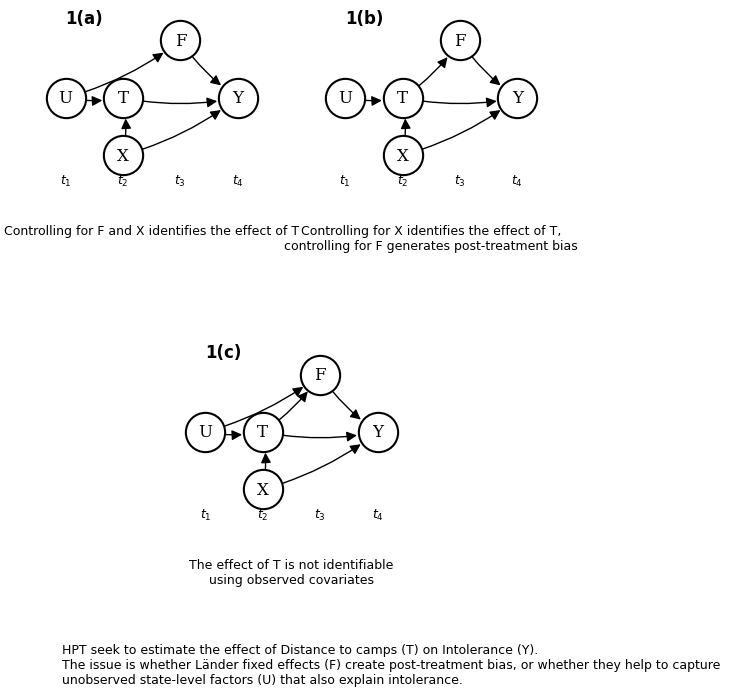

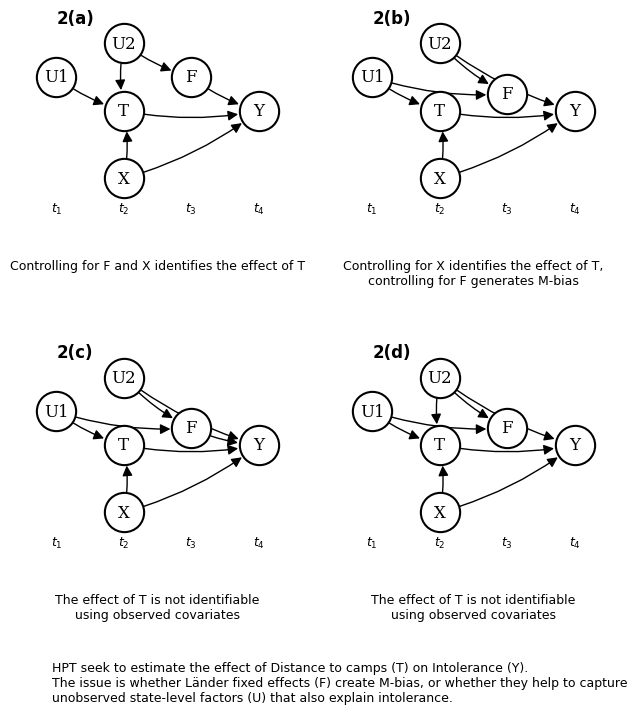


Done! Both figures have been saved as PDF files.


In [2]:
"""
Python translation of create_dags.R
Creates Directed Acyclic Graphs (DAGs) illustrating post-treatment bias and M-bias
for the paper: "Modeling Spatial Heterogeneity and Historical Persistence"

Required packages: networkx, matplotlib, numpy
"""

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import numpy as np
from itertools import combinations


# ============================================================================
# Helper functions for DAG operations
# ============================================================================

def create_dag(edges, coords):
    """
    Create a directed acyclic graph with specified edges and node coordinates.
    
    Parameters:
    -----------
    edges : list of tuples
        List of (parent, child) edges representing causal relationships
    coords : dict
        Dictionary mapping node names to (x, y) coordinates
    
    Returns:
    --------
    G : nx.DiGraph
        Directed graph with position attributes
    """
    G = nx.DiGraph()
    G.add_edges_from(edges)
    
    # Add coordinates as node attributes
    for node, (x, y) in coords.items():
        if node in G.nodes():
            G.nodes[node]['pos'] = (x, y)
        else:
            G.add_node(node, pos=(x, y))
    
    return G


def get_ancestors(G, node):
    """Get all ancestors of a node in the DAG."""
    return nx.ancestors(G, node)


def get_descendants(G, node):
    """Get all descendants of a node in the DAG."""
    return nx.descendants(G, node)


def find_all_paths(G, source, target, undirected=True):
    """
    Find all paths between source and target.
    If undirected=True, treats edges as undirected for path finding.
    """
    if undirected:
        G_undirected = G.to_undirected()
        return list(nx.all_simple_paths(G_undirected, source, target))
    return list(nx.all_simple_paths(G, source, target))


def is_collider(G, path, node):
    """Check if a node is a collider on a path."""
    if node not in path:
        return False
    idx = path.index(node)
    if idx == 0 or idx == len(path) - 1:
        return False
    
    prev_node = path[idx - 1]
    next_node = path[idx + 1]
    
    # A node is a collider if both adjacent nodes on the path point TO it
    return G.has_edge(prev_node, node) and G.has_edge(next_node, node)


def is_path_blocked(G, path, conditioning_set):
    """
    Check if a path is blocked given a conditioning set (d-separation).
    
    A path is blocked if:
    1. It contains a non-collider that is in the conditioning set, OR
    2. It contains a collider where neither the collider nor its descendants 
       are in the conditioning set
    """
    for i, node in enumerate(path[1:-1], 1):  # Exclude endpoints
        prev_node = path[i - 1]
        next_node = path[i + 1]
        
        # Check if node is a collider on this path
        is_coll = G.has_edge(prev_node, node) and G.has_edge(next_node, node)
        
        if is_coll:
            # Collider: path is blocked unless collider or descendant is conditioned on
            collider_descendants = get_descendants(G, node)
            if node not in conditioning_set and not any(d in conditioning_set for d in collider_descendants):
                return True
        else:
            # Non-collider: path is blocked if conditioned on
            if node in conditioning_set:
                return True
    
    return False


def find_adjustment_sets(G, treatment, outcome, observed=None):
    """
    Find valid adjustment sets for estimating the causal effect of treatment on outcome.
    
    This implements a simplified version of the adjustment set algorithm.
    
    Parameters:
    -----------
    G : nx.DiGraph
        The causal DAG
    treatment : str
        The treatment variable
    outcome : str
        The outcome variable
    observed : set, optional
        Set of observed variables. If None, all non-treatment, non-outcome variables are observed.
    
    Returns:
    --------
    list of frozensets
        Valid adjustment sets
    """
    all_nodes = set(G.nodes())
    
    if observed is None:
        observed = all_nodes - {treatment, outcome}
    
    # Get descendants of treatment (cannot adjust for these - would create post-treatment bias)
    treatment_descendants = get_descendants(G, treatment)
    
    # Candidates for adjustment are observed variables that are not descendants of treatment
    # and not the treatment or outcome themselves
    candidates = observed - treatment_descendants - {treatment, outcome}
    
    valid_sets = []
    
    # Check all possible subsets of candidates
    for r in range(len(candidates) + 1):
        for subset in combinations(candidates, r):
            conditioning_set = set(subset)
            
            # Check if this conditioning set blocks all backdoor paths
            # A backdoor path is any path from T to Y that starts with an arrow INTO T
            
            # Get all paths between treatment and outcome (treating graph as undirected)
            all_paths = find_all_paths(G, treatment, outcome, undirected=True)
            
            # Filter to backdoor paths (paths that start with an edge INTO treatment)
            backdoor_paths = []
            for path in all_paths:
                if len(path) >= 2:
                    second_node = path[1]
                    # Check if the edge goes INTO treatment (backdoor)
                    if G.has_edge(second_node, treatment):
                        backdoor_paths.append(path)
            
            # Check if all backdoor paths are blocked
            all_blocked = True
            for path in backdoor_paths:
                if not is_path_blocked(G, path, conditioning_set):
                    all_blocked = False
                    break
            
            if all_blocked:
                valid_sets.append(frozenset(subset))
    
    # Return minimal adjustment sets (remove supersets)
    minimal_sets = []
    for s in valid_sets:
        is_minimal = True
        for other in valid_sets:
            if other < s:  # other is a proper subset
                is_minimal = False
                break
        if is_minimal:
            minimal_sets.append(s)
    
    return minimal_sets


def adjustment_sets_to_string(adj_sets):
    """Convert adjustment sets to a readable string format."""
    if not adj_sets:
        return "No valid adjustment set exists"
    
    result = []
    for s in adj_sets:
        if len(s) == 0:
            result.append("{ }")
        else:
            result.append("{ " + ", ".join(sorted(s)) + " }")
    
    return "\n".join(result)


# ============================================================================
# Plotting functions
# ============================================================================

def plot_dag(G, ax, title="", subtitle="", time_labels=None, node_size=800, 
             font_size=12, title_pos=(-1, 2.3)):
    """
    Plot a DAG on the given axes.
    
    Parameters:
    -----------
    G : nx.DiGraph
        The DAG to plot
    ax : matplotlib.axes.Axes
        The axes to plot on
    title : str
        Title for the subplot (e.g., "1(a)")
    subtitle : str
        Explanatory text below the graph
    time_labels : list, optional
        List of (x, label) tuples for time axis labels
    node_size : int
        Size of the nodes
    font_size : int
        Font size for node labels
    title_pos : tuple
        (x, y) position for the title
    """
    pos = nx.get_node_attributes(G, 'pos')
    
    # Draw edges with arrows
    nx.draw_networkx_edges(G, pos, ax=ax, 
                          edge_color='black',
                          arrows=True,
                          arrowsize=15,
                          arrowstyle='-|>',
                          connectionstyle='arc3,rad=0.1',
                          min_source_margin=15,
                          min_target_margin=15)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, ax=ax,
                          node_color='white',
                          node_size=node_size,
                          edgecolors='black',
                          linewidths=1.5)
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, ax=ax,
                           font_size=font_size,
                           font_family='serif')
    
    # Add title
    if title:
        ax.text(title_pos[0], title_pos[1], title, fontsize=12, fontweight='bold')
    
    # Add subtitle
    if subtitle:
        ax.text(0.5, -1.2, subtitle, fontsize=9, ha='center', va='top',
               transform=ax.transData, wrap=True)
    
    # Add time labels
    if time_labels:
        for x, label in time_labels:
            ax.text(x, -0.5, label, fontsize=9, ha='center', style='italic')
    
    # Set axis properties
    ax.set_xlim(-1.5, 2.5)
    ax.set_ylim(-1.5, 2.5)
    ax.set_aspect('equal')
    ax.axis('off')


# ============================================================================
# Figure 1: Post-treatment bias DAGs
# ============================================================================

def create_figure1():
    """Create Figure 1: DAGs illustrating post-treatment bias."""
    
    # Common coordinates for Figure 1
    coords_fig1 = {
        'Y': (2, 1),
        'T': (0, 1),
        'U': (-1, 1),
        'F': (1, 2),
        'X': (0, 0)
    }
    
    time_labels = [(-1, '$t_1$'), (0, '$t_2$'), (1, '$t_3$'), (2, '$t_4$')]
    
    # DAG 1(a): Controlling for F and X identifies the effect of T
    # Y ~ T + F + X, F ~ U, T ~ U + X
    edges_1a = [
        ('T', 'Y'), ('F', 'Y'), ('X', 'Y'),
        ('U', 'F'),
        ('U', 'T'), ('X', 'T')
    ]
    dag1a = create_dag(edges_1a, coords_fig1)
    adj_sets_1a = find_adjustment_sets(dag1a, 'T', 'Y', observed={'F', 'X'})
    print("DAG 1(a) adjustment sets:", adjustment_sets_to_string(adj_sets_1a))
    
    # DAG 1(b): Controlling for X identifies T; controlling for F generates post-treatment bias
    # Y ~ T + F + X, F ~ T, T ~ U + X
    edges_1b = [
        ('T', 'Y'), ('F', 'Y'), ('X', 'Y'),
        ('T', 'F'),
        ('U', 'T'), ('X', 'T')
    ]
    dag1b = create_dag(edges_1b, coords_fig1)
    adj_sets_1b = find_adjustment_sets(dag1b, 'T', 'Y', observed={'F', 'X'})
    print("DAG 1(b) adjustment sets:", adjustment_sets_to_string(adj_sets_1b))
    
    # DAG 1(c): Effect of T is not identifiable
    # Y ~ T + F + X, F ~ T + U, T ~ U + X
    edges_1c = [
        ('T', 'Y'), ('F', 'Y'), ('X', 'Y'),
        ('T', 'F'), ('U', 'F'),
        ('U', 'T'), ('X', 'T')
    ]
    dag1c = create_dag(edges_1c, coords_fig1)
    adj_sets_1c = find_adjustment_sets(dag1c, 'T', 'Y', observed={'F', 'X'})
    print("DAG 1(c) adjustment sets:", adjustment_sets_to_string(adj_sets_1c))
    
    # Create figure
    fig = plt.figure(figsize=(7, 7.5))
    gs = GridSpec(3, 4, figure=fig, height_ratios=[1, 1, 0.15])
    
    # Plot 1(a) - top left, spans 2 columns
    ax1a = fig.add_subplot(gs[0, 0:2])
    plot_dag(dag1a, ax1a, title="1(a)",
            subtitle="Controlling for F and X identifies the effect of T",
            time_labels=time_labels)
    
    # Plot 1(b) - top right, spans 2 columns
    ax1b = fig.add_subplot(gs[0, 2:4])
    plot_dag(dag1b, ax1b, title="1(b)",
            subtitle="Controlling for X identifies the effect of T,\ncontrolling for F generates post-treatment bias",
            time_labels=time_labels)
    
    # Plot 1(c) - middle center, spans 2 columns
    ax1c = fig.add_subplot(gs[1, 1:3])
    plot_dag(dag1c, ax1c, title="1(c)",
            subtitle="The effect of T is not identifiable\nusing observed covariates",
            time_labels=time_labels)
    
    # Add caption at bottom
    caption = ("HPT seek to estimate the effect of Distance to camps (T) on Intolerance (Y).\n"
               "The issue is whether Länder fixed effects (F) create post-treatment bias, or whether they help to capture\n"
               "unobserved state-level factors (U) that also explain intolerance.")
    
    ax_caption = fig.add_subplot(gs[2, :])
    ax_caption.text(0.05, 0.5, caption, fontsize=9, ha='left', va='center',
                   transform=ax_caption.transAxes)
    ax_caption.axis('off')
    
    plt.tight_layout()
    return fig


# ============================================================================
# Figure 2: M-bias DAGs
# ============================================================================

def create_figure2():
    """Create Figure 2: DAGs illustrating M-bias."""
    
    time_labels = [(-1, '$t_1$'), (0, '$t_2$'), (1, '$t_3$'), (2, '$t_4$')]
    
    # Coordinates for Figure 2(a)
    coords_2a = {
        'Y': (2, 1),
        'T': (0, 1),
        'U1': (-1, 1.5),
        'U2': (0, 2),
        'F': (1, 1.5),
        'X': (0, 0)
    }
    
    # DAG 2(a): Controlling for F and X identifies the effect of T
    # Y ~ T + F + X, F ~ U2, T ~ U1 + U2 + X
    edges_2a = [
        ('T', 'Y'), ('F', 'Y'), ('X', 'Y'),
        ('U2', 'F'),
        ('U1', 'T'), ('U2', 'T'), ('X', 'T')
    ]
    dag2a = create_dag(edges_2a, coords_2a)
    adj_sets_2a = find_adjustment_sets(dag2a, 'T', 'Y', observed={'F', 'X'})
    print("DAG 2(a) adjustment sets:", adjustment_sets_to_string(adj_sets_2a))
    
    # Coordinates for Figure 2(b), 2(c), 2(d)
    coords_2bcd = {
        'Y': (2, 1),
        'T': (0, 1),
        'U1': (-1, 1.5),
        'U2': (0, 2),
        'F': (1, 1.25),
        'X': (0, 0)
    }
    
    # DAG 2(b): Controlling for X identifies T; controlling for F generates M-bias
    # Y ~ T + X + U2, F ~ U1 + U2, T ~ U1 + X
    edges_2b = [
        ('T', 'Y'), ('X', 'Y'), ('U2', 'Y'),
        ('U1', 'F'), ('U2', 'F'),
        ('U1', 'T'), ('X', 'T')
    ]
    dag2b = create_dag(edges_2b, coords_2bcd)
    adj_sets_2b = find_adjustment_sets(dag2b, 'T', 'Y', observed={'F', 'X'})
    print("DAG 2(b) adjustment sets:", adjustment_sets_to_string(adj_sets_2b))
    
    # DAG 2(c): Effect of T is not identifiable
    # Y ~ T + F + X + U2, F ~ U2 + U1, T ~ U1 + X
    edges_2c = [
        ('T', 'Y'), ('F', 'Y'), ('X', 'Y'), ('U2', 'Y'),
        ('U2', 'F'), ('U1', 'F'),
        ('U1', 'T'), ('X', 'T')
    ]
    dag2c = create_dag(edges_2c, coords_2bcd)
    adj_sets_2c = find_adjustment_sets(dag2c, 'T', 'Y', observed={'F', 'X'})
    print("DAG 2(c) adjustment sets:", adjustment_sets_to_string(adj_sets_2c))
    
    # DAG 2(d): Effect of T is not identifiable
    # Y ~ T + X + U2, F ~ U2 + U1, T ~ U1 + X + U2
    edges_2d = [
        ('T', 'Y'), ('X', 'Y'), ('U2', 'Y'),
        ('U2', 'F'), ('U1', 'F'),
        ('U1', 'T'), ('X', 'T'), ('U2', 'T')
    ]
    dag2d = create_dag(edges_2d, coords_2bcd)
    adj_sets_2d = find_adjustment_sets(dag2d, 'T', 'Y', observed={'F', 'X'})
    print("DAG 2(d) adjustment sets:", adjustment_sets_to_string(adj_sets_2d))
    
    # Create figure
    fig = plt.figure(figsize=(7, 7.5))
    gs = GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 0.15])
    
    # Plot 2(a) - top left
    ax2a = fig.add_subplot(gs[0, 0])
    plot_dag(dag2a, ax2a, title="2(a)",
            subtitle="Controlling for F and X identifies the effect of T",
            time_labels=time_labels)
    
    # Plot 2(b) - top right
    ax2b = fig.add_subplot(gs[0, 1])
    plot_dag(dag2b, ax2b, title="2(b)",
            subtitle="Controlling for X identifies the effect of T,\ncontrolling for F generates M-bias",
            time_labels=time_labels)
    
    # Plot 2(c) - bottom left
    ax2c = fig.add_subplot(gs[1, 0])
    plot_dag(dag2c, ax2c, title="2(c)",
            subtitle="The effect of T is not identifiable\nusing observed covariates",
            time_labels=time_labels)
    
    # Plot 2(d) - bottom right
    ax2d = fig.add_subplot(gs[1, 1])
    plot_dag(dag2d, ax2d, title="2(d)",
            subtitle="The effect of T is not identifiable\nusing observed covariates",
            time_labels=time_labels)
    
    # Add caption at bottom
    caption = ("HPT seek to estimate the effect of Distance to camps (T) on Intolerance (Y).\n"
               "The issue is whether Länder fixed effects (F) create M-bias, or whether they help to capture\n"
               "unobserved state-level factors (U) that also explain intolerance.")
    
    ax_caption = fig.add_subplot(gs[2, :])
    ax_caption.text(0.05, 0.5, caption, fontsize=9, ha='left', va='center',
                   transform=ax_caption.transAxes)
    ax_caption.axis('off')
    
    plt.tight_layout()
    return fig


# ============================================================================
# Main execution
# ============================================================================

if __name__ == "__main__":
    print("=" * 60)
    print("Creating Figure 1: Post-treatment Bias DAGs")
    print("=" * 60)
    fig1 = create_figure1()
    fig1.savefig("figure1.pdf", bbox_inches='tight', dpi=300)
    print("\nSaved figure1.pdf")
    
    print("\n" + "=" * 60)
    print("Creating Figure 2: M-bias DAGs")
    print("=" * 60)
    fig2 = create_figure2()
    fig2.savefig("figure2.pdf", bbox_inches='tight', dpi=300)
    print("\nSaved figure2.pdf")
    
    plt.show()
    
    print("\n" + "=" * 60)
    print("Done! Both figures have been saved as PDF files.")
    print("=" * 60)